In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances
from mpl_toolkits.mplot3d import Axes3D
import swifter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalMaxPooling2D

In [4]:
DATASET_PATH = "./myntradataset/"
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=5000, error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)

In [5]:
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
     
def img_path(img):
    return DATASET_PATH+"/images/"+img

def load_image(img):
    return cv2.imread(img_path(img))

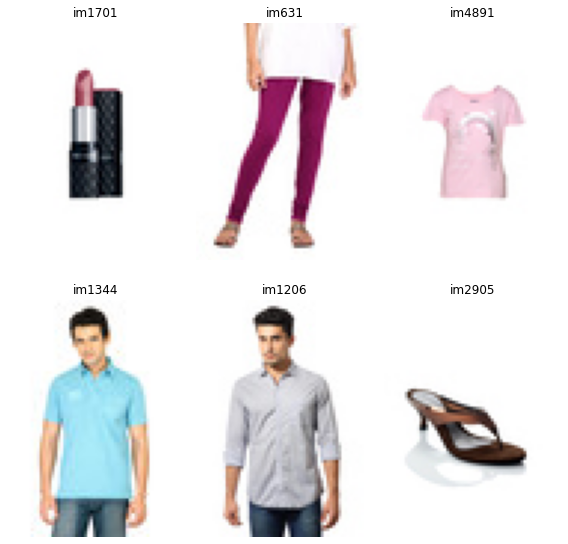

In [6]:
figures = {'im'+str(i): load_image(row.image) for i, row in df.sample(6).iterrows()}
plot_figures(figures, 2, 3)

In [7]:
img_width, img_height, _ = load_image(df.iloc[0].image).shape
 
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False
 
model = tf.keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])
 
model.summary()

94773248/94765736 [==============================] - 93s 1us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 2, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
def get_embedding(model, img_name):
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    x   = image.img_to_array(img)
    x   = np.expand_dims(x, axis=0)
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [9]:
%%time
map_embeddings = df['image'].swifter.apply(lambda img: get_embedding(model, img))
df_embs        = map_embeddings.apply(pd.Series)
print(df_embs.shape)
df_embs.head()


(5000, 2048)
Wall time: 10min 58s


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.000000,3.651431,0.000000,0.752217,0.000000,0.000000,4.103793,2.382156,2.472526,0.0,...,0.366394,0.000000,0.000000,6.000694,0.000000,0.000000,6.389914,4.246402,1.067720,1.671666
1,1.879337,1.600881,0.092031,4.433074,0.000000,0.000000,3.030768,8.530594,5.498661,0.0,...,2.808288,0.000000,3.923483,3.183100,0.000000,0.000000,4.244203,3.268898,2.271732,5.433381
2,0.000000,0.311200,0.000000,3.808686,0.437028,7.112502,0.000000,0.000000,0.000000,0.0,...,0.218204,7.861302,1.655932,0.000000,0.000000,0.000000,4.703017,0.000000,2.340578,0.000000
3,0.588018,9.894615,0.000000,6.295307,1.783728,1.913123,0.000000,13.309944,7.805778,0.0,...,22.434378,0.000000,0.000000,0.000000,2.565927,3.330477,0.594362,1.130467,3.084236,7.608930
4,0.000000,1.882976,0.000000,5.122099,0.000000,0.000000,2.950293,6.626859,1.606631,0.0,...,2.504942,0.000000,1.274129,3.484578,0.786349,0.000000,1.597857,2.515497,0.068349,0.000000


In [10]:
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
indices = pd.Series(range(len(df)), index=df.index)
 
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
     
    return indices.iloc[idx_rec].index, idx_sim
 
get_recommender(2993, df, top_n = 5)

(Int64Index([259, 4305, 0, 2779, 2701], dtype='int64'),
 [0.9071895, 0.8946352, 0.89189005, 0.8889795, 0.88077486])

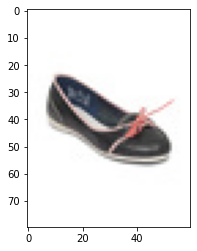

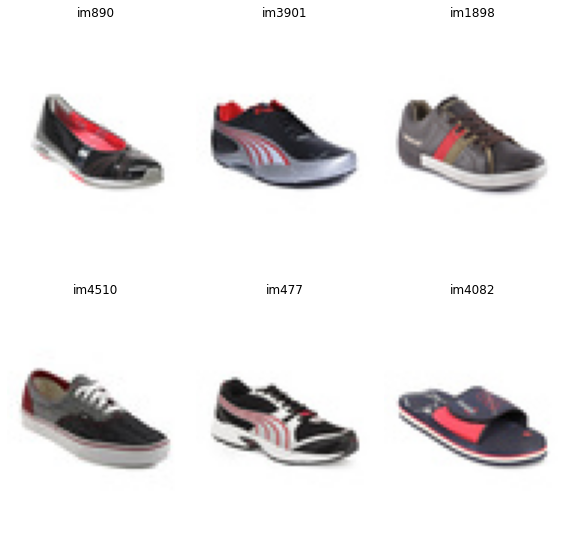

In [11]:
from random import randint
 
idx_ref = randint(1, 5000)
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))
 
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
plot_figures(figures, 2, 3)

In [ ]:
df_embs.to_csv('embeddings.csv')
df.to_csv('metadados.csv')
df.sample(100).to_csv('df_sample.csv')